In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Objective : Create a sphere where alternate quadrants are white and black, and perform blurring using several filters.

Blank Image


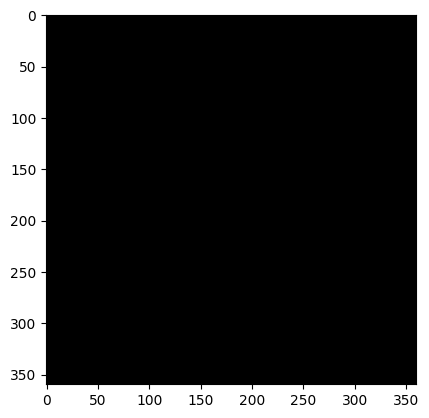

In [2]:
IMG_DIMS = (360,360)
CENTER = (IMG_DIMS[0]//2, IMG_DIMS[1]//2)
RADIUS = 160

WHITE = (255, 255, 255)

image = np.zeros(IMG_DIMS, dtype=np.uint8)

print("Blank Image")
plt.imshow(image, cmap='gray')

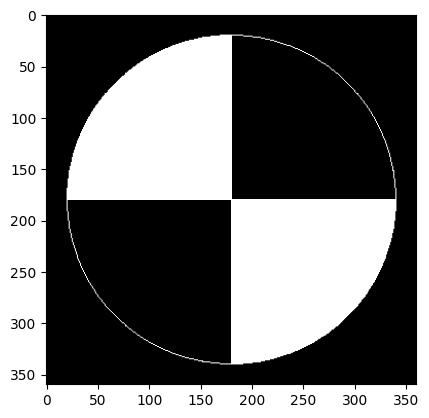

In [3]:
# Draw Quadrants.
image = cv2.ellipse(image, CENTER, axes=(RADIUS, RADIUS), angle=0, startAngle=0, endAngle=90, color=WHITE)
image = cv2.ellipse(image, CENTER, axes=(RADIUS, RADIUS), angle=0, startAngle=90, endAngle=180, color=WHITE)
image = cv2.ellipse(image, CENTER, axes=(RADIUS, RADIUS), angle=0, startAngle=180, endAngle=270, color=WHITE)
image = cv2.ellipse(image, CENTER, axes=(RADIUS, RADIUS), angle=0, startAngle=270, endAngle=360, color=WHITE)

# Draw lines to seperate quadrants.
image = cv2.line(image, (IMG_DIMS[0]//2 - 160, IMG_DIMS[1]//2), (IMG_DIMS[0]//2 + 160, IMG_DIMS[1]//2), color=WHITE)
image = cv2.line(image, (IMG_DIMS[0]//2, IMG_DIMS[1]//2 - RADIUS), (IMG_DIMS[0]//2, IMG_DIMS[1]//2 + RADIUS), color=WHITE)

# Fill in colors.
cv2.floodFill(image, None, (IMG_DIMS[0]//2 - 80, IMG_DIMS[1]//2 - RADIUS//2), 255)
cv2.floodFill(image, None, (IMG_DIMS[0]//2 + 80, IMG_DIMS[1]//2 + RADIUS//2), 255)
plt.imshow(image, cmap='gray')

Averaging / Box Blur

average blur filter : (3x3)


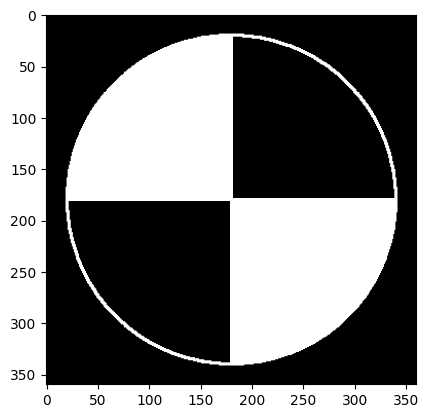

average blur filter : (5x5)


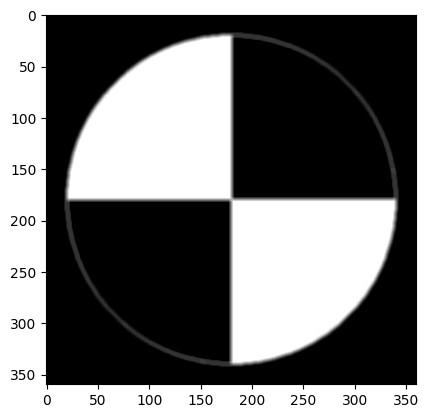

average blur filter : (9x9)


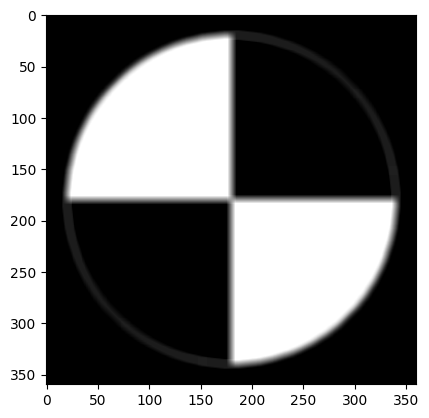

In [4]:
average_blur_filter_3 = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
average_blurred_image_3 = cv2.filter2D(image, -1, average_blur_filter_3)

average_blurred_image_5 = cv2.blur(image, (5, 5))

average_blurred_image_9 = cv2.blur(image, (9, 9))

print('average blur filter : (3x3)')
plt.imshow(average_blurred_image_3, cmap='gray')

plt.show()

print('average blur filter : (5x5)')
plt.imshow(average_blurred_image_5, cmap='gray')

plt.show()

print('average blur filter : (9x9)')
plt.imshow(average_blurred_image_9, cmap='gray')

Gaussian Blur

Central pixel has higher weightage that other pixels (weightage decreases as distance from center increases)

gaussian blur filter : (3x3)


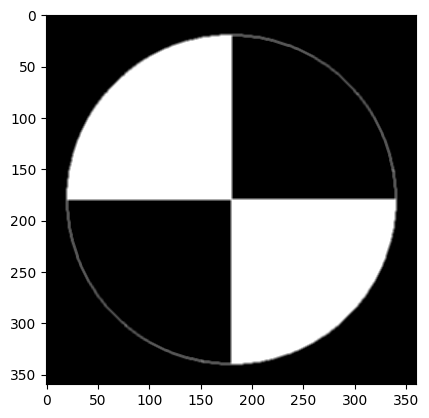

gaussian blur filter : (9x9)


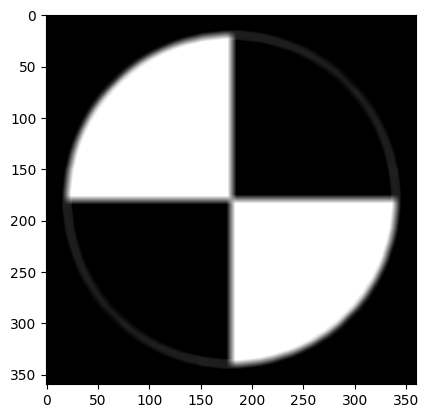

gaussian blur filter : (11x11)


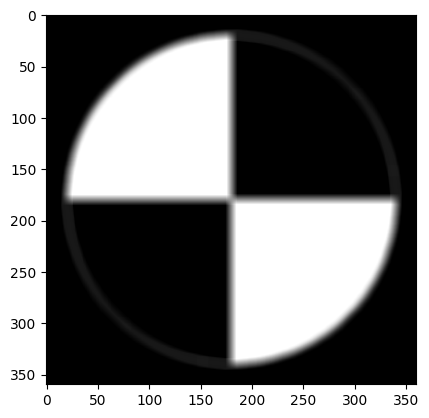

gaussian blur filter : (21x21)


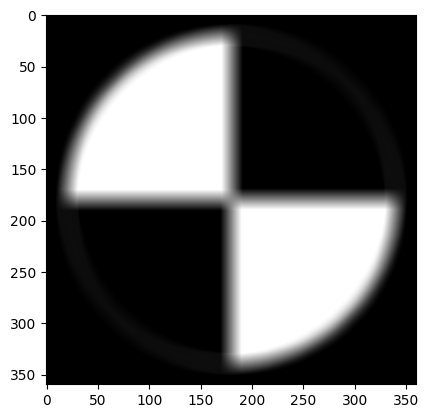

In [5]:
for i in  (3, 9, 11, 21):
    gaussian_blur = cv2.GaussianBlur(image, (i, i), i)

    print('gaussian blur filter : ({}x{})'.format(i, i))
    plt.imshow(gaussian_blur, cmap='gray')

    plt.show()

Median Blur

Good for noise remove, replaces each element with median of neighbourhood

median blur filter : (3x3)


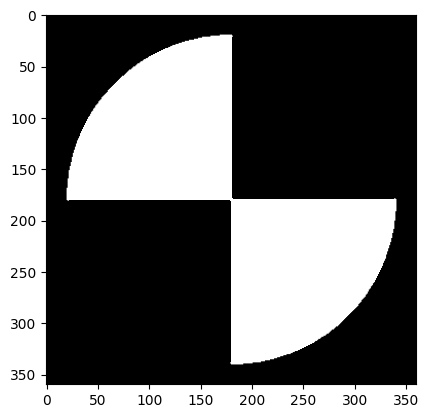

median blur filter : (9x9)


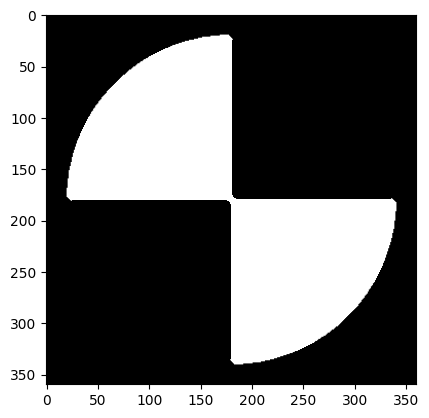

median blur filter : (11x11)


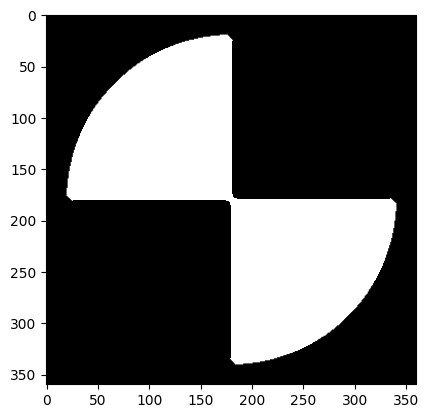

median blur filter : (21x21)


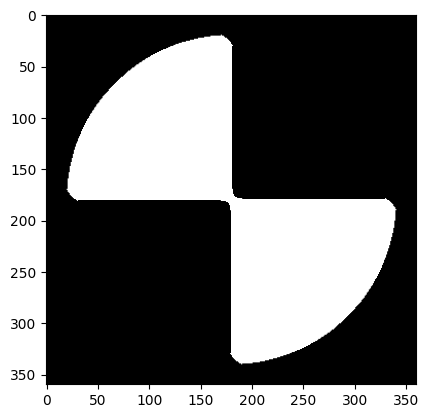

In [6]:
for i in  (3, 9, 11, 21):
    median_blur = cv2.medianBlur(image, i)

    print('median blur filter : ({}x{})'.format(i, i))
    plt.imshow(median_blur, cmap='gray')

    plt.show()

Bilateral Blur


Reserve edges while blurring rest of image. Areas with high contrast are blurred less than areas of low contrast.


bilateral_blur blur filter : (3x3)


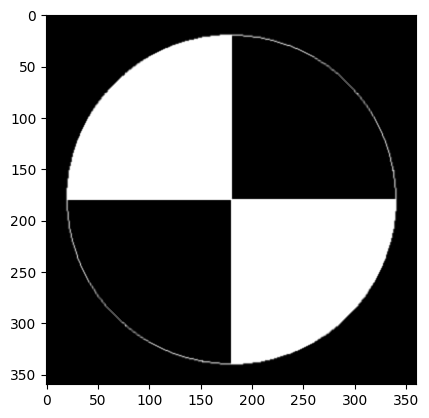

bilateral_blur blur filter : (9x9)


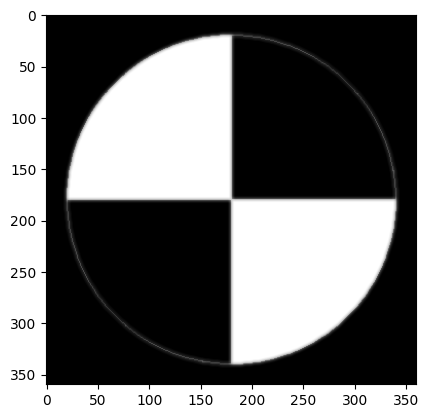

bilateral_blur blur filter : (11x11)


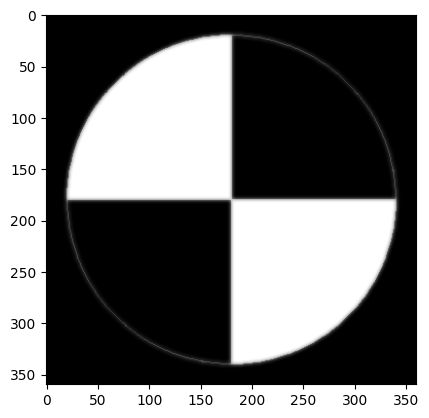

bilateral_blur blur filter : (21x21)


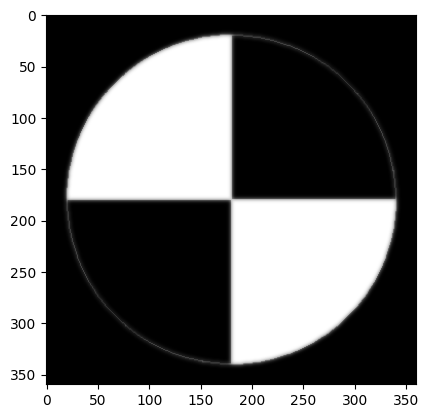

bilateral_blur blur filter : (99x99)


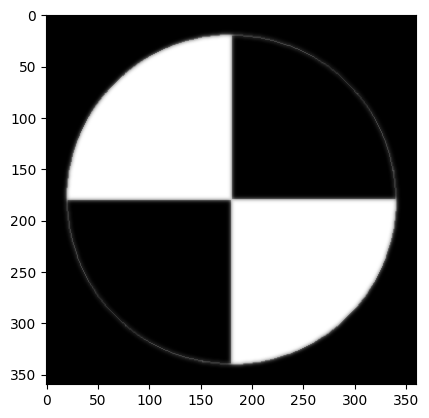

In [7]:
for i in  (3, 9, 11, 21, 99):
    bilateral_blur = cv2.bilateralFilter(image, i, 255, 2)

    print('bilateral_blur blur filter : ({}x{})'.format(i, i))
    plt.imshow(bilateral_blur, cmap='gray')

    plt.show()

Frequency domain filtering (Low pass)

Ideal low pass filter

A frequency domain low pass filter satisfiying the property : 
H(u, v) = {1 if D(u, v) >= D0, 0 if D(U, v) < D0) \
Here, D(u, v) is given by sqrt((u - M / 2) ** 2 + (v - N / 2) ** 2) \
D0 is the cutoff frequency of the image (or the radius of the circle encompassing the low frequency componenets of frequency domain image). \
Blurs image, but produces significant blurring.

In [8]:
def create_ilpf(size, d0): 
    m, n = size
    H = np.zeros(size, dtype=np.float32)
    for u in range(m):
        for v in range(n):
            d = np.sqrt((u - m / 2)**2 + (v - n / 2) ** 2)
            if d <= d0:
                # Inside the allowed - frequency range
                H[u, v] = 1
            else:
                H[u, v] = 0
  
    return H

In [9]:
ilp_filters = []
for i in range(1, 10):
  ilp_filters.append(create_ilpf(IMG_DIMS, i * 10))

plt.figure(figsize=IMG_DIMS)

for i in range(1, 9):
  plt.subplot(1,10, i)
  plt.imshow(ilp_filters[i],cmap='gray')
  plt.title(('ILP D0->' + str(i * 10)))
  plt.axis('on')

plt.show()

In [10]:
# Assume iamge is in spatial domain
def apply_freq_filter(filter, image):
  ft = np.fft.fft2(image)
  ft_shifted = np.fft.fftshift(ft)

  g = ft_shifted * filter

  g_spatial = np.fft.ifftshift(g)
  g_spatial = np.fft.ifft2(g_spatial)

  return g, g_spatial

<Figure size 3000x500 with 0 Axes>

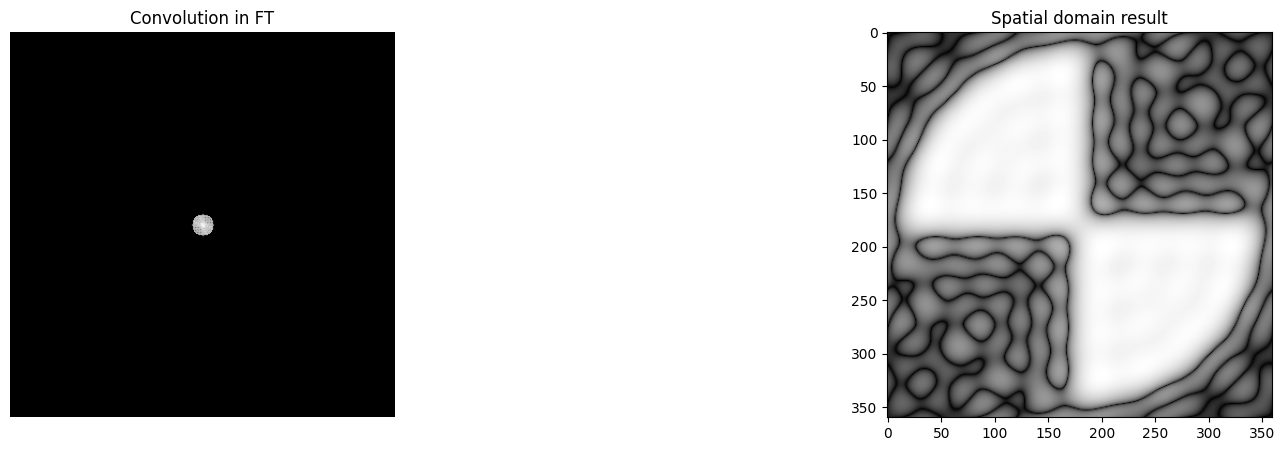

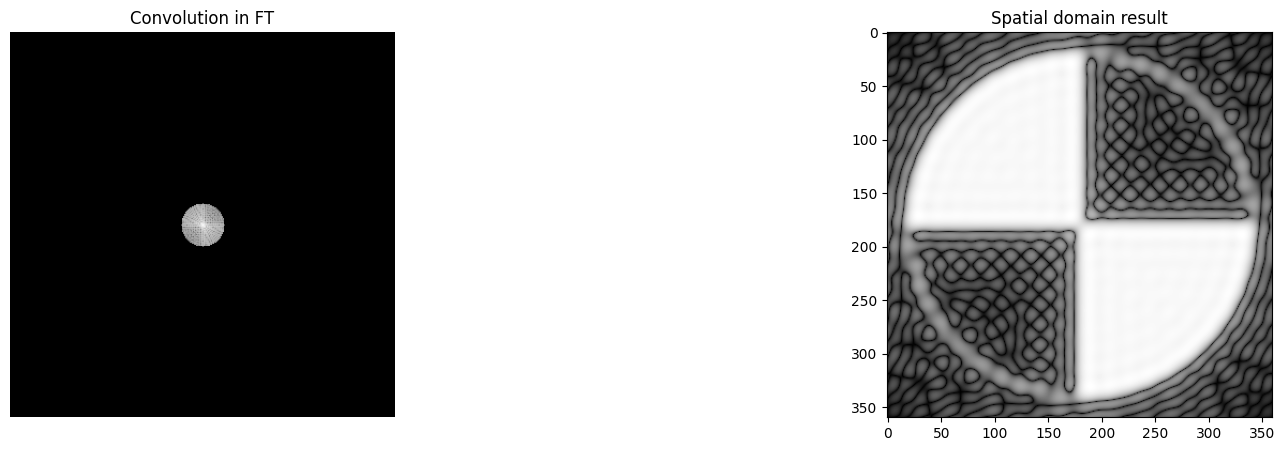

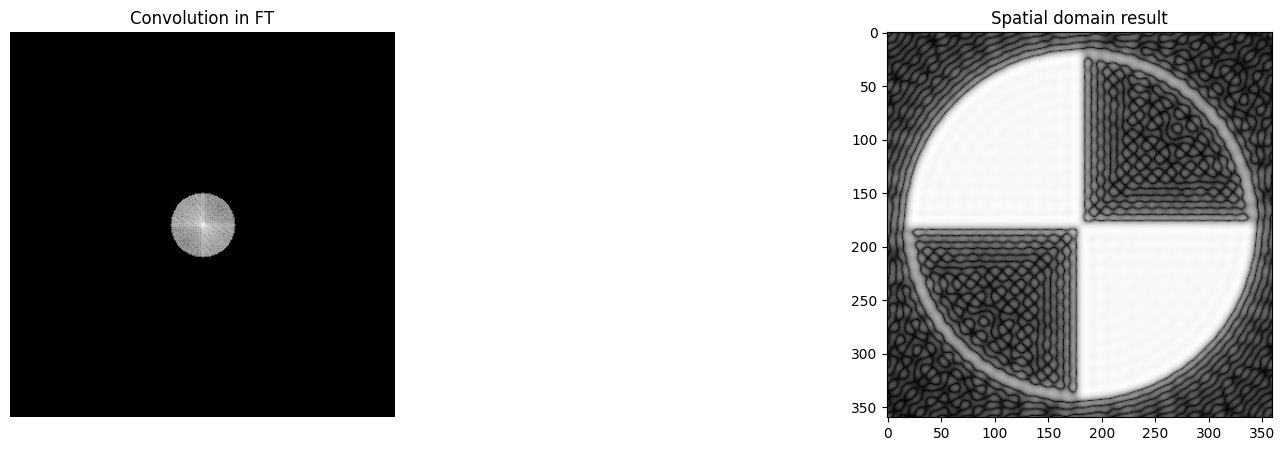

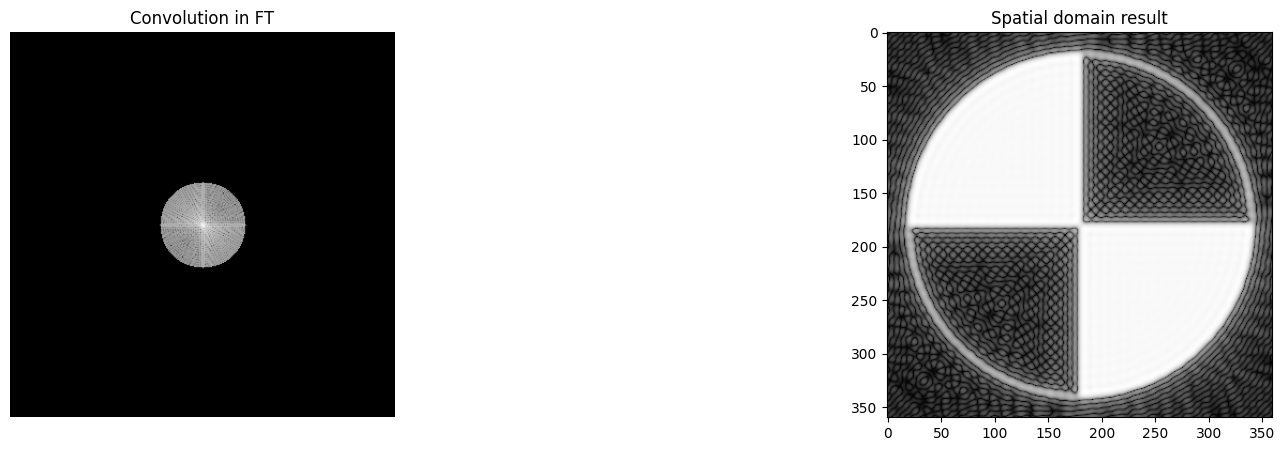

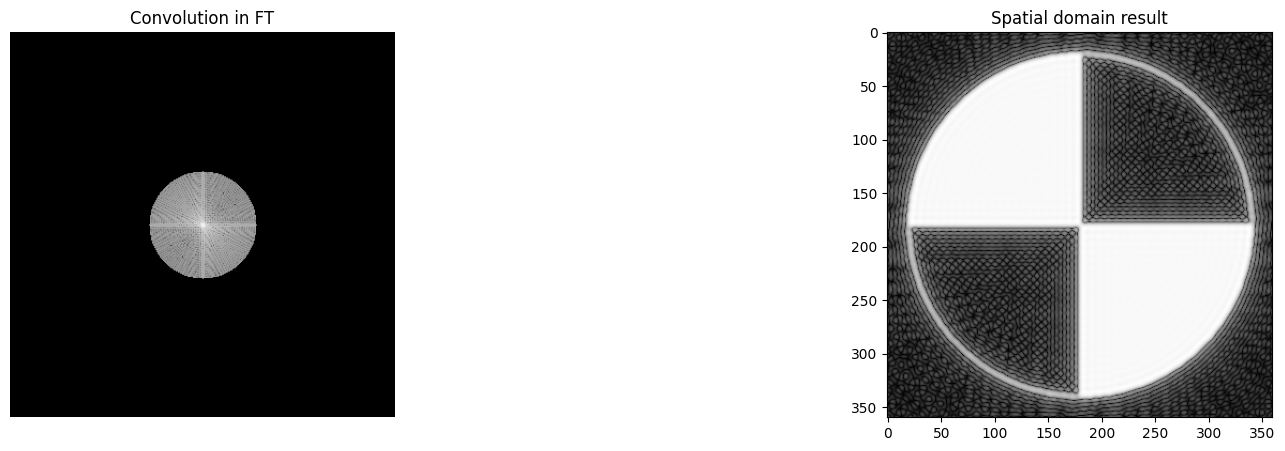

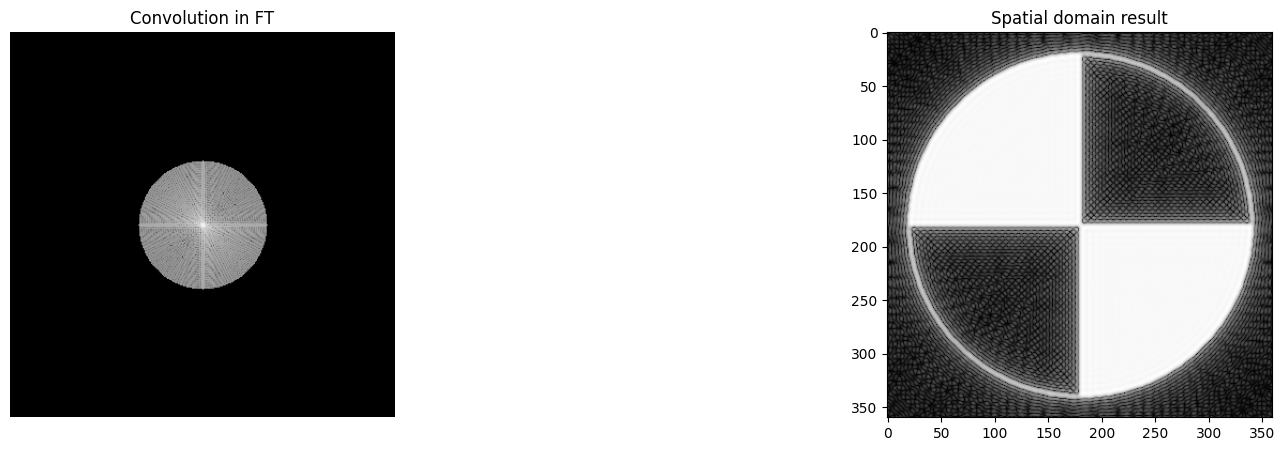

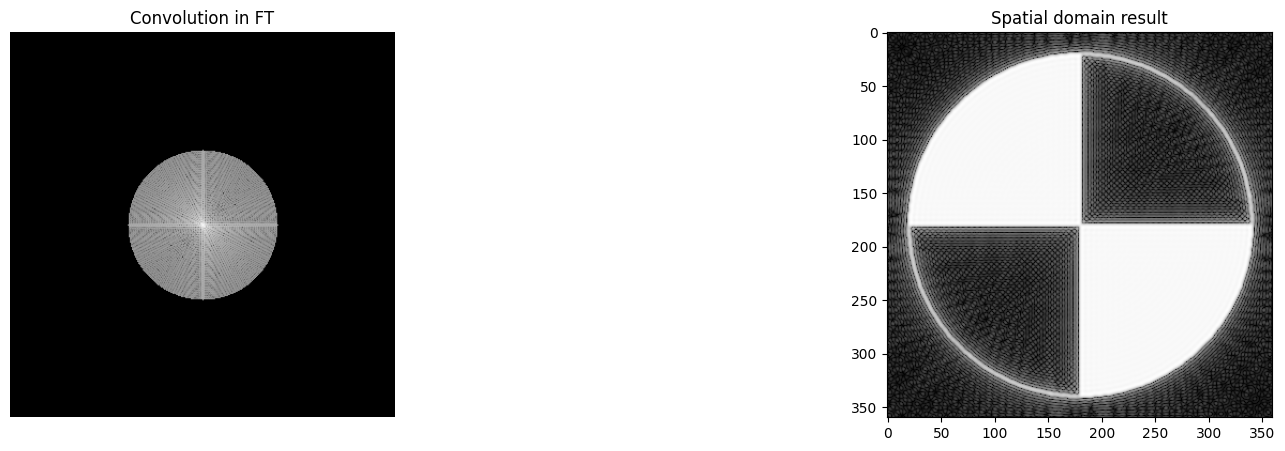

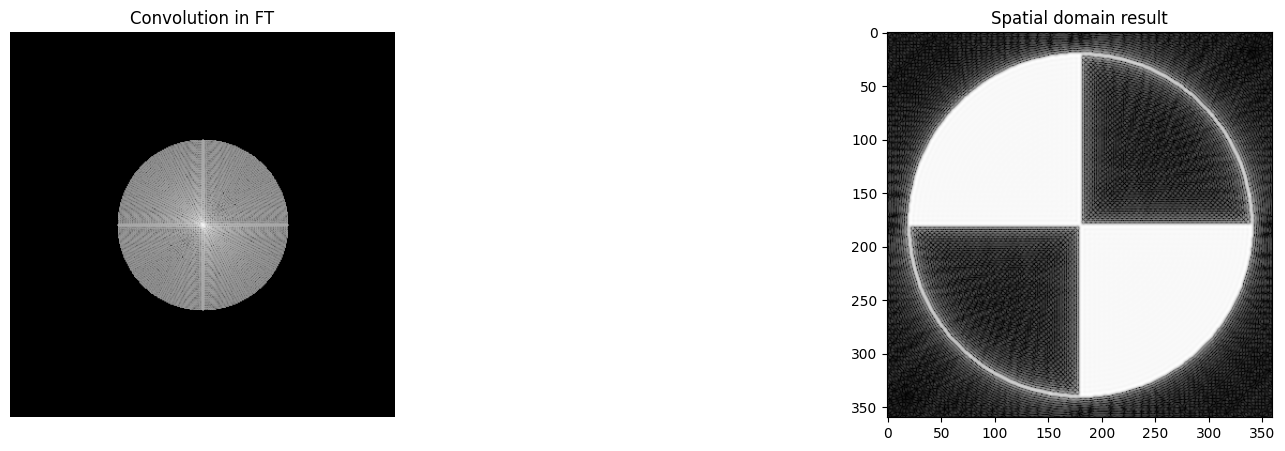

In [11]:
ilpf, ilp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_freq_filter(ilp_filters[i], image)
  ilpf.append(g)
  ilp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(ilpf[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  plt.imshow(np.log1p(np.abs(ilp_applied[i])),cmap='gray')
  plt.title('Spatial domain result')
  plt.axis('on')

plt.show()

# The Butterworth Low Pass Filter

A frequency domain given by :
H(u, v) = 1 / (1 + (D / D0) ^ 2n) \
Where, \
D = sqrt((u - m / 2) ** 2 + (v - n / 2) ** 2) \
D0 = cut off frequency \
n = order of filter 

In [12]:
def butter_worth_low_pass(image, d0, order):
  m, n = image.shape
  H = np.zeros((m, n), dtype=np.float64)
  for u in range(m):
    for v in range(n):
      d = np.sqrt((u - m / 2) ** 2 + (v - n / 2) ** 2)
      H[u, v] = 1 / (1 + (d/d0) ** (2 * order))

  return H

C:\Users\Tarun\AppData\Local\Temp\ipykernel_11124\4229668697.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10, i)


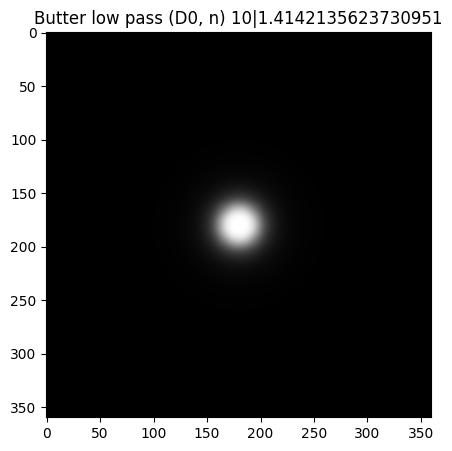

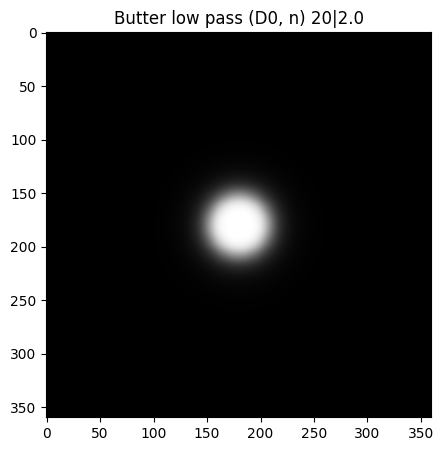

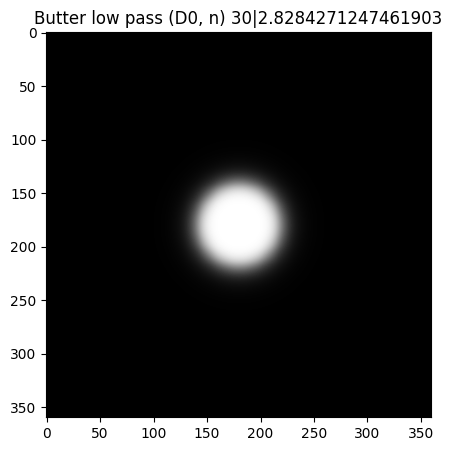

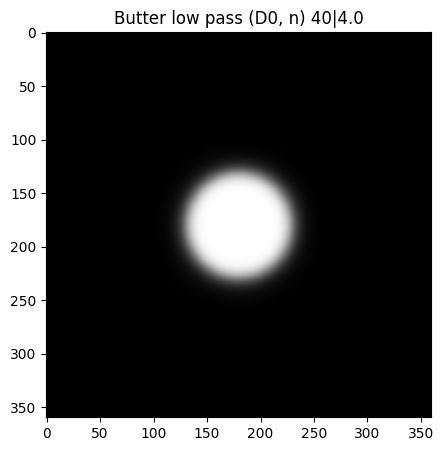

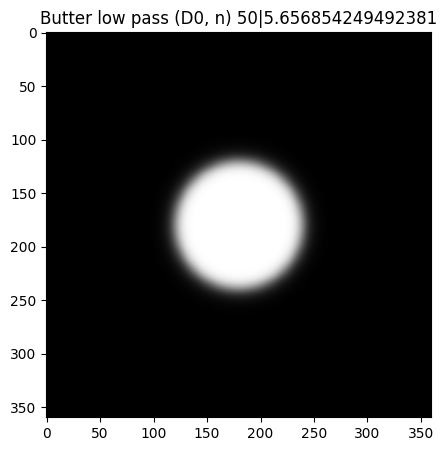

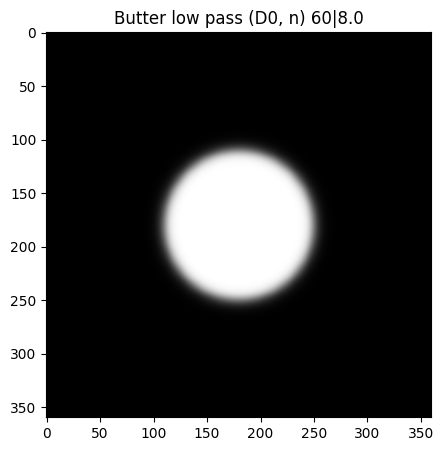

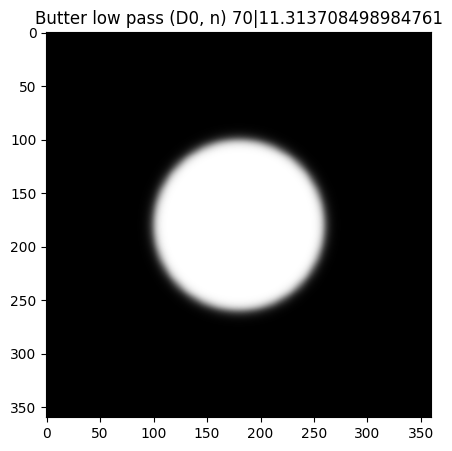

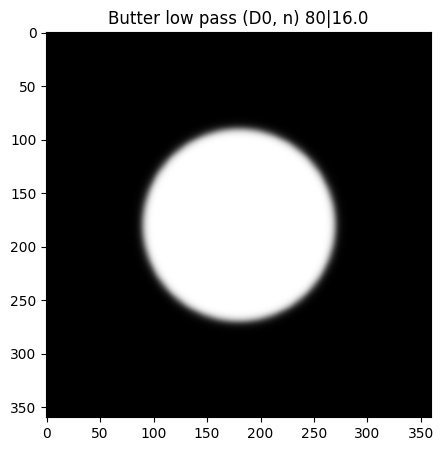

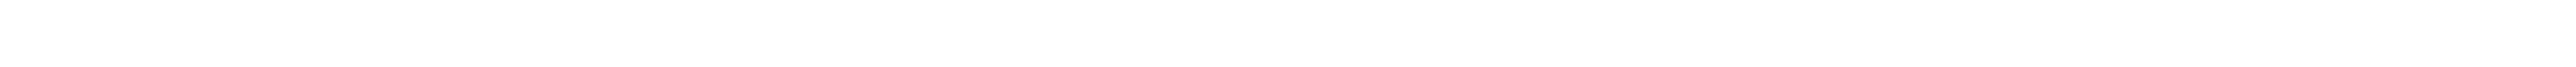

<Figure size 20000x500 with 0 Axes>

<Figure size 20000x500 with 0 Axes>

In [13]:
butter_worth_low_pass_filters = []
for i in range(1, 10):
  butter_worth_low_pass_filters.append(butter_worth_low_pass(image, i * 10, 2 ** (i/2)))

plt.figure(figsize=(200,5))

for i in range(1, 9):
  plt.subplot(1,10, i)
  plt.imshow(butter_worth_low_pass_filters[i],cmap='gray')
  plt.title(('Butter low pass (D0, n) ' + str(i * 10) + '|' + str(2 ** (i/2))))
  plt.figure(figsize=(200,5))

  plt.axis('off')

plt.show()

plt.figure(figsize=(200,5))

<Figure size 3000x500 with 0 Axes>

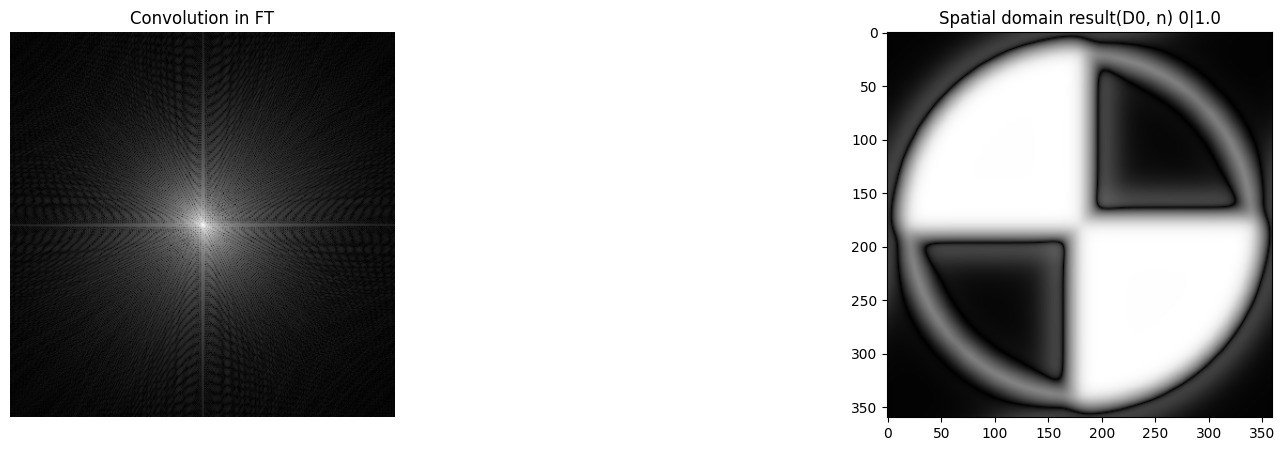

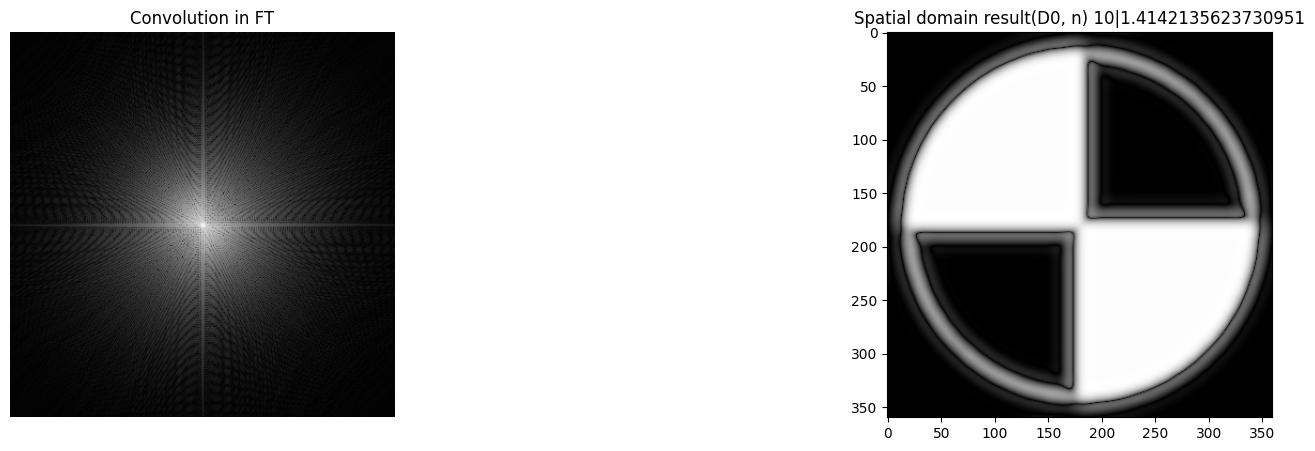

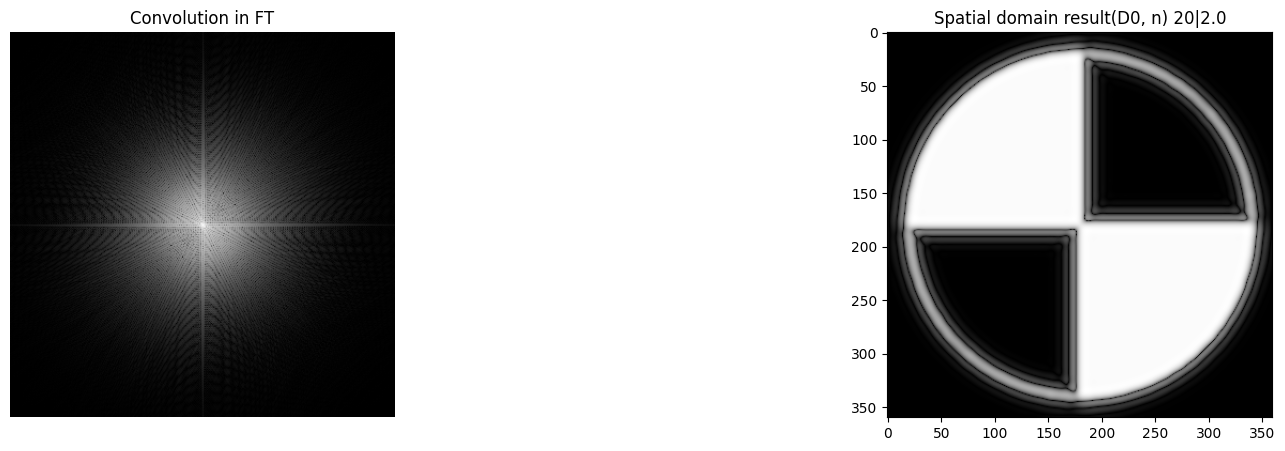

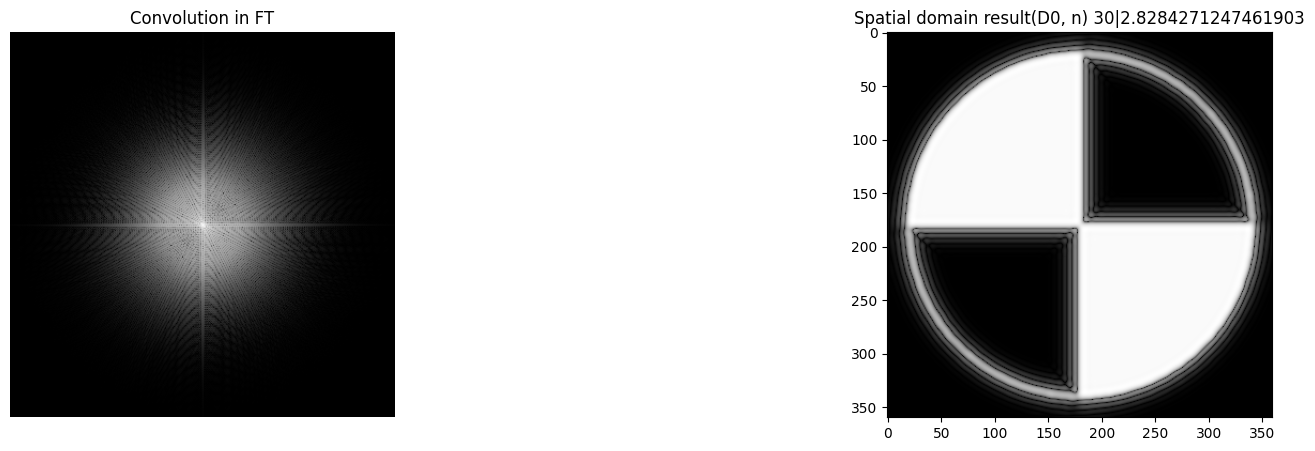

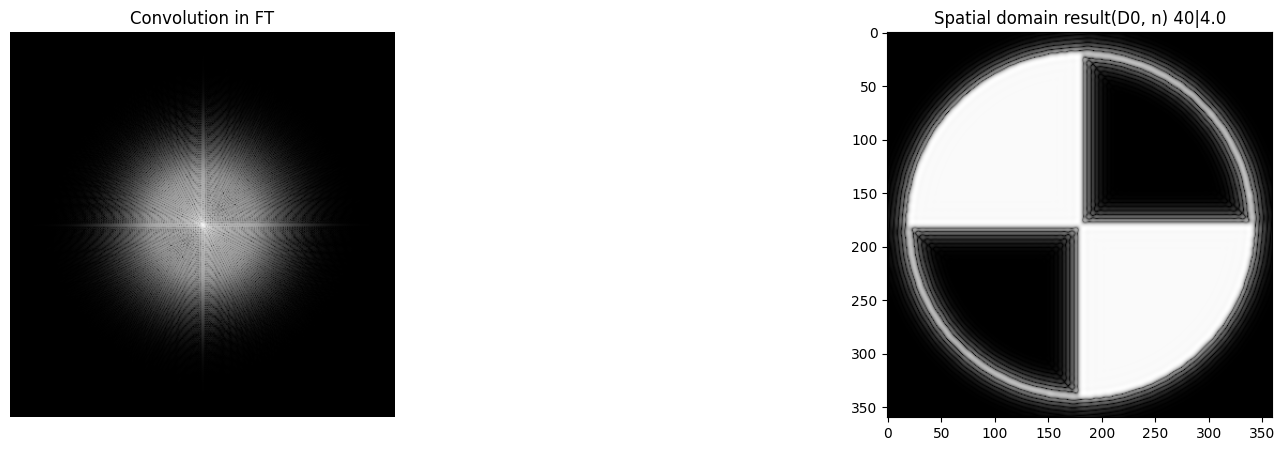

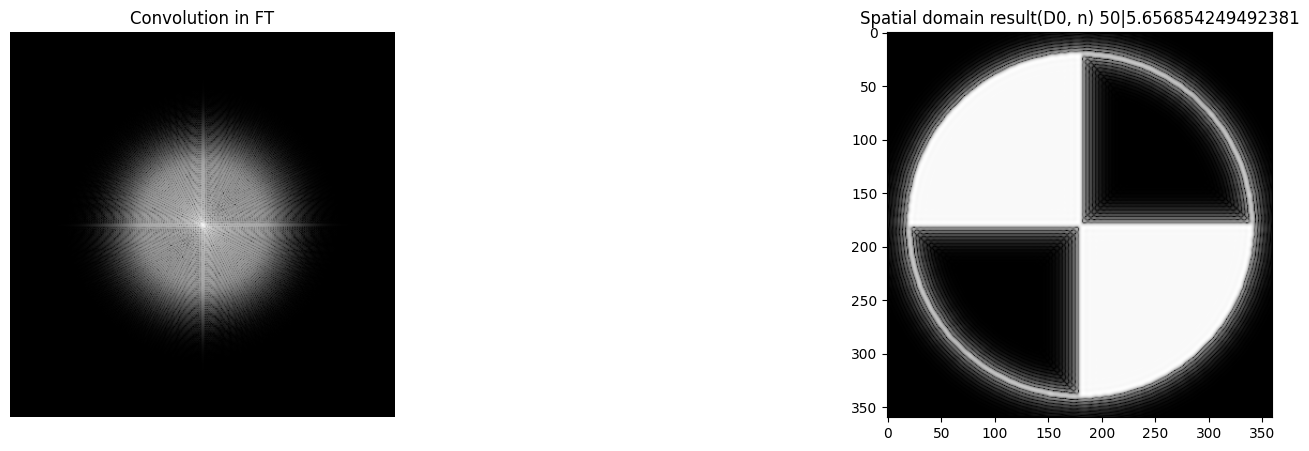

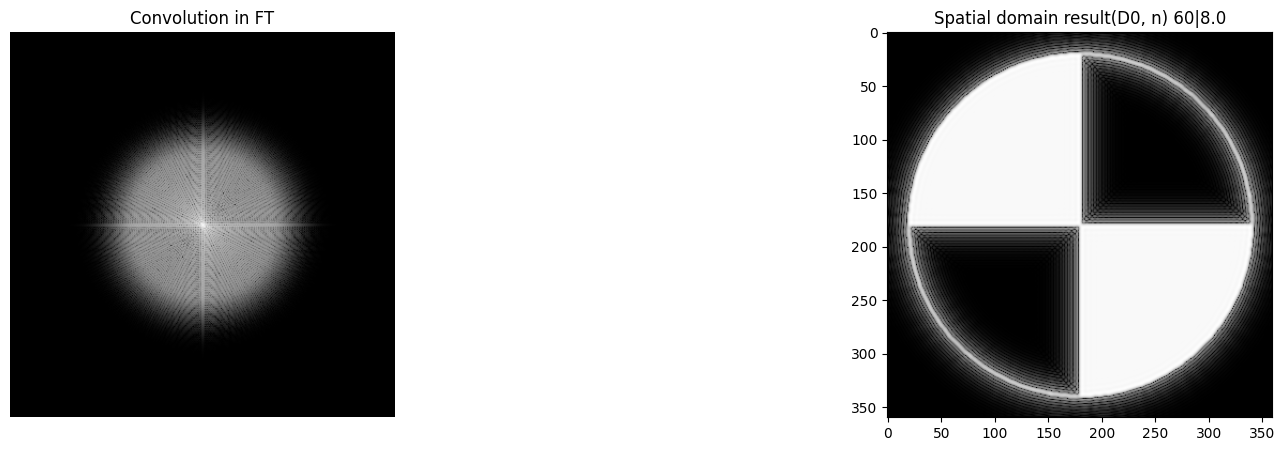

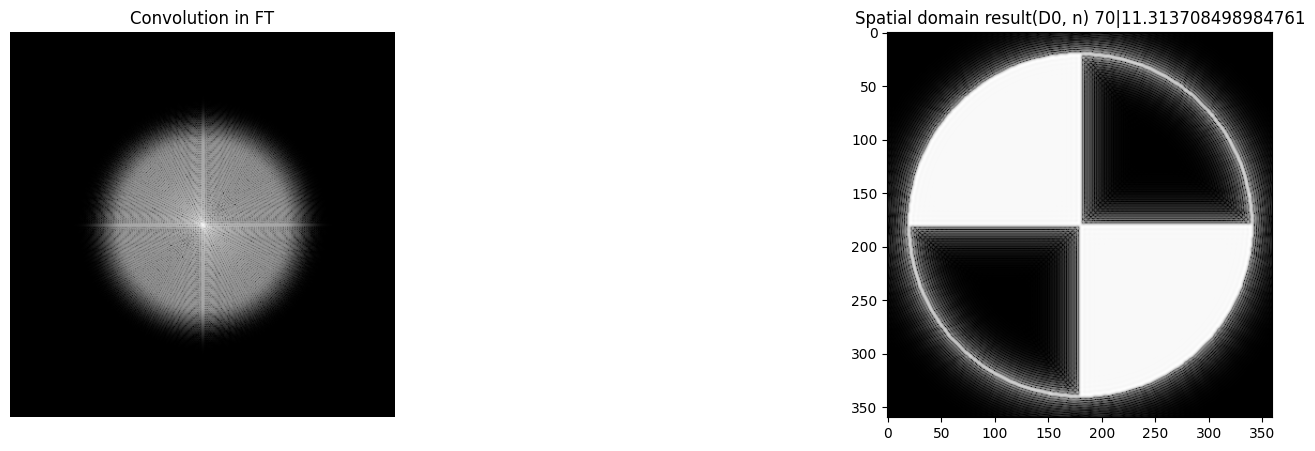

In [14]:
blpf, blp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_freq_filter(butter_worth_low_pass_filters[i], image)
  blpf.append(g)
  blp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(blpf[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  plt.imshow(np.log1p(np.abs(blp_applied[i])),cmap='gray')
  plt.title('Spatial domain result' + str('(D0, n) ') + str(i * 10) + '|' + str(2 ** (i/2)))

  plt.axis('on')

plt.show()

Gaussian Blur

No ringing affect (unlike ideal low high and butter worth low pass).

In [21]:
def create_glpf(size, d0):
    m,n  = size
    H = np.zeros((m, n), dtype=np.float32)
    for u in range(m):
        for v in range(n):
            d = np.sqrt((u-m/2)**2 + (v-n/2)**2)
            H[u,v] = np.exp(-d**2/(2*d0*d0))

    return H

C:\Users\Tarun\AppData\Local\Temp\ipykernel_11124\3013254620.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10, i)


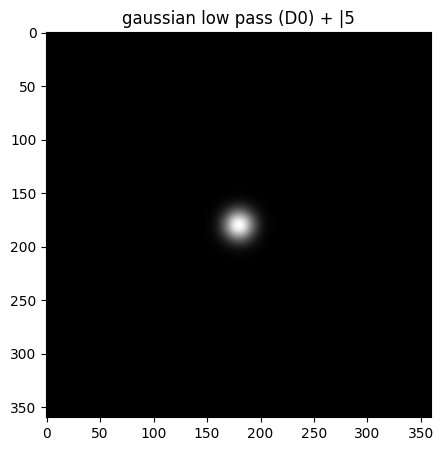

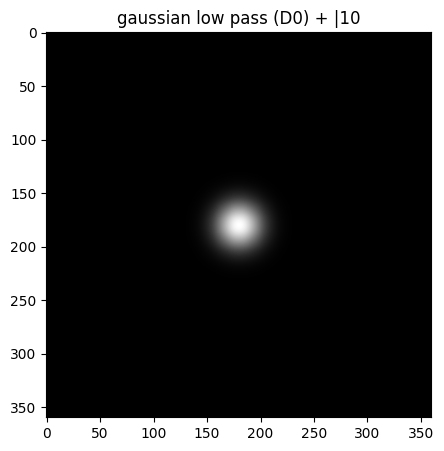

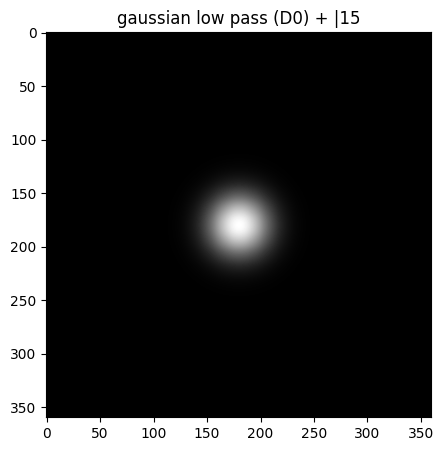

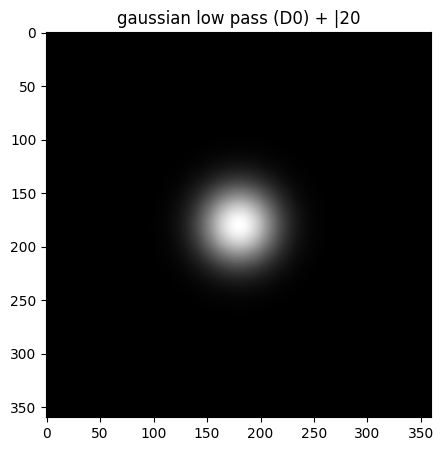

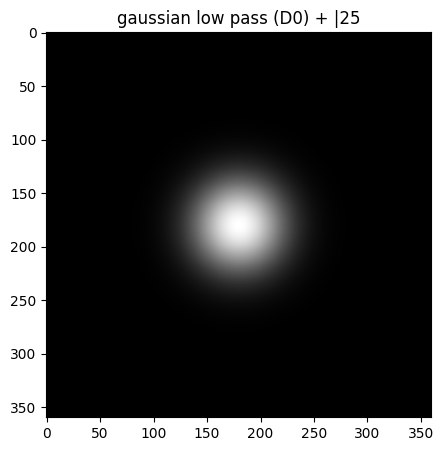

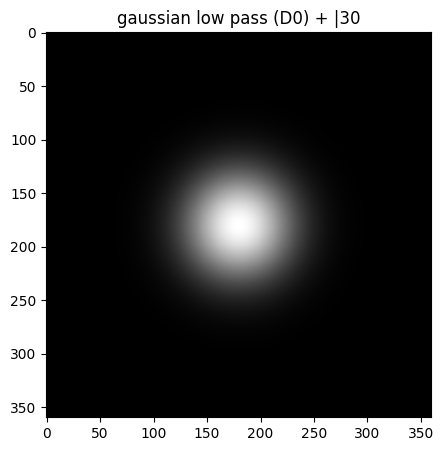

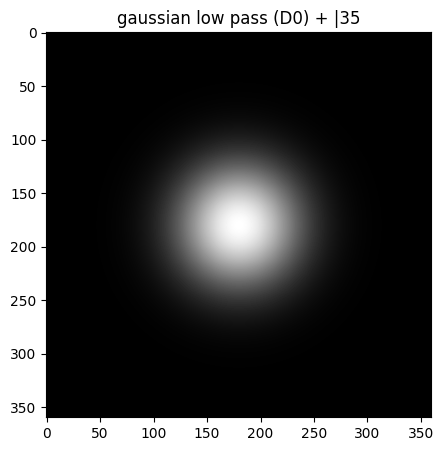

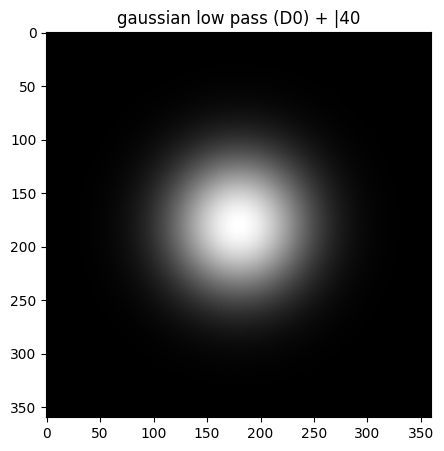

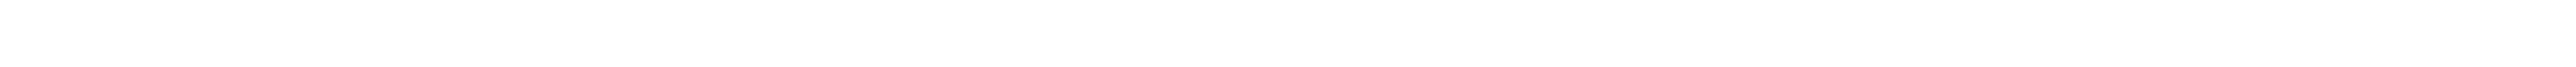

<Figure size 20000x500 with 0 Axes>

<Figure size 20000x500 with 0 Axes>

In [26]:
gaussian_low_pass_filters = []
for i in range(1, 10):
  gaussian_low_pass_filters.append(create_glpf(IMG_DIMS, i * 5))

plt.figure(figsize=(200,5))

for i in range(1, 9):
  plt.subplot(1,10, i)
  plt.imshow(gaussian_low_pass_filters[i],cmap='gray')
  plt.title(('gaussian low pass (D0) + |' + str(i  * 5)))
  plt.figure(figsize=(200,5))

  plt.axis('off')

plt.show()

plt.figure(figsize=(200,5))

<Figure size 3000x500 with 0 Axes>

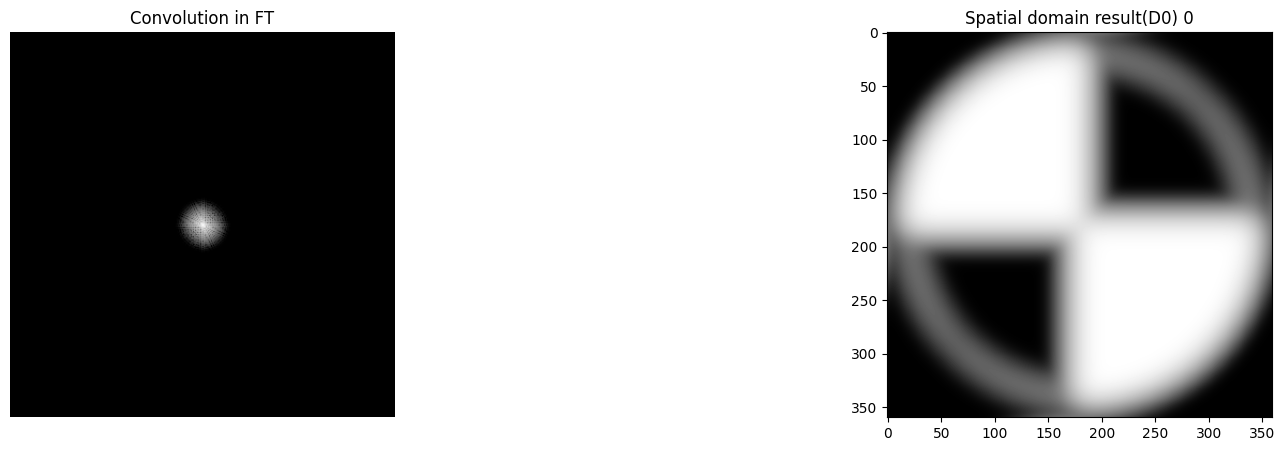

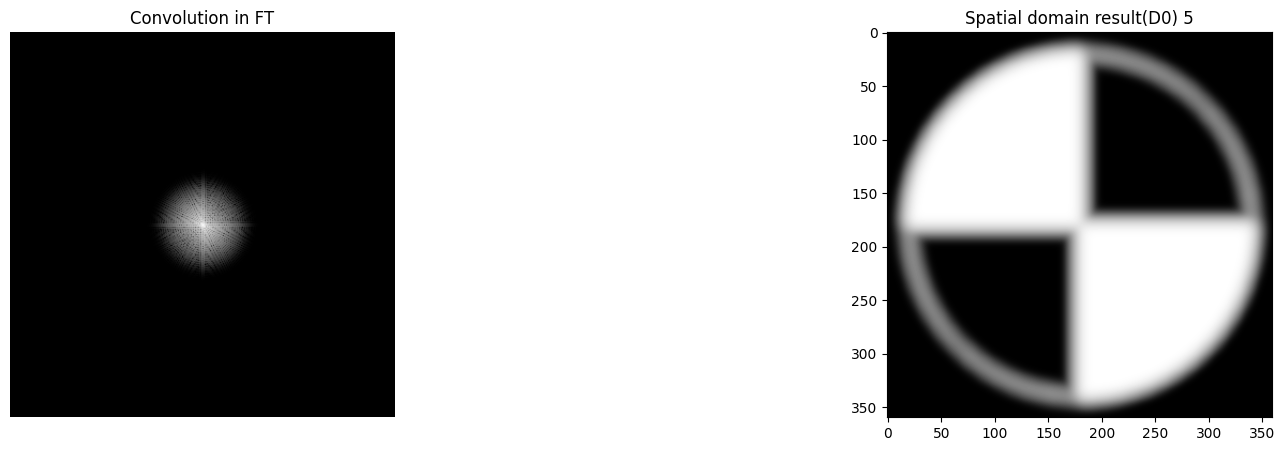

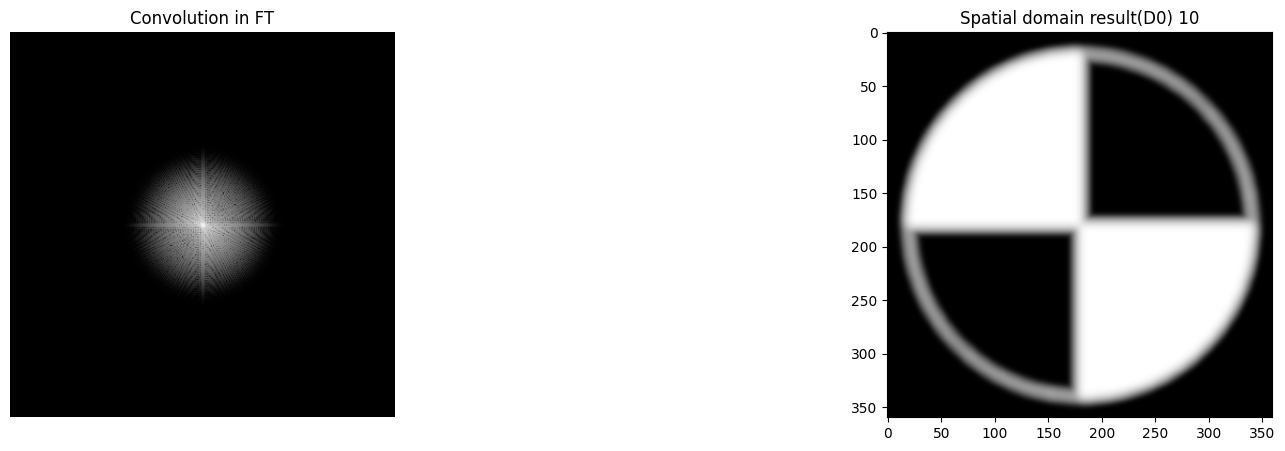

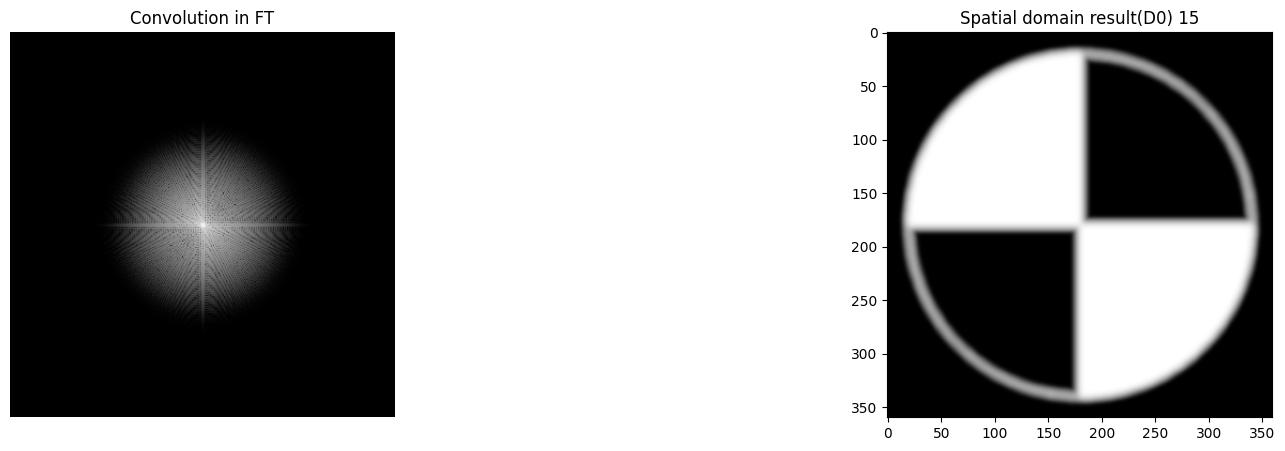

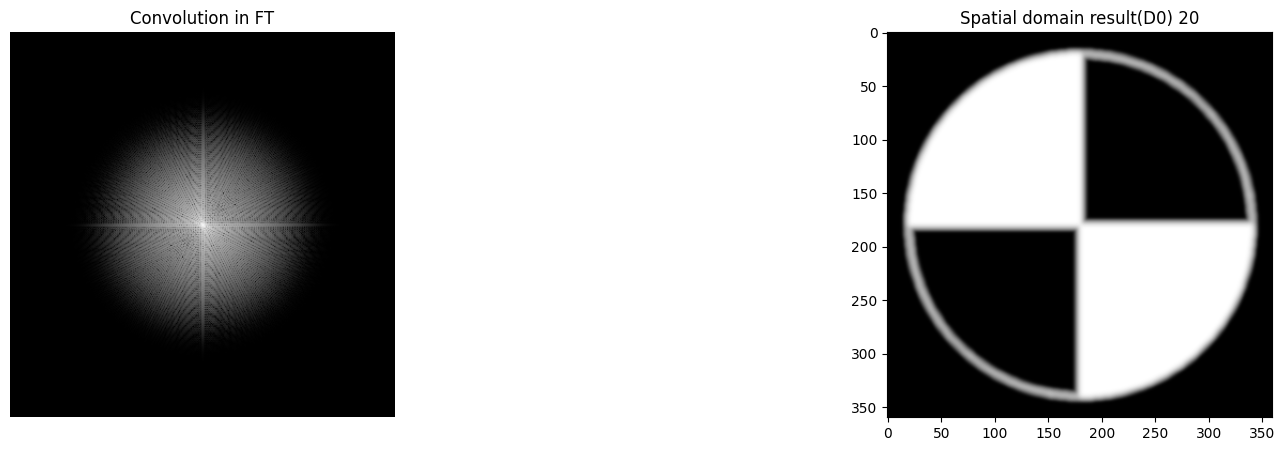

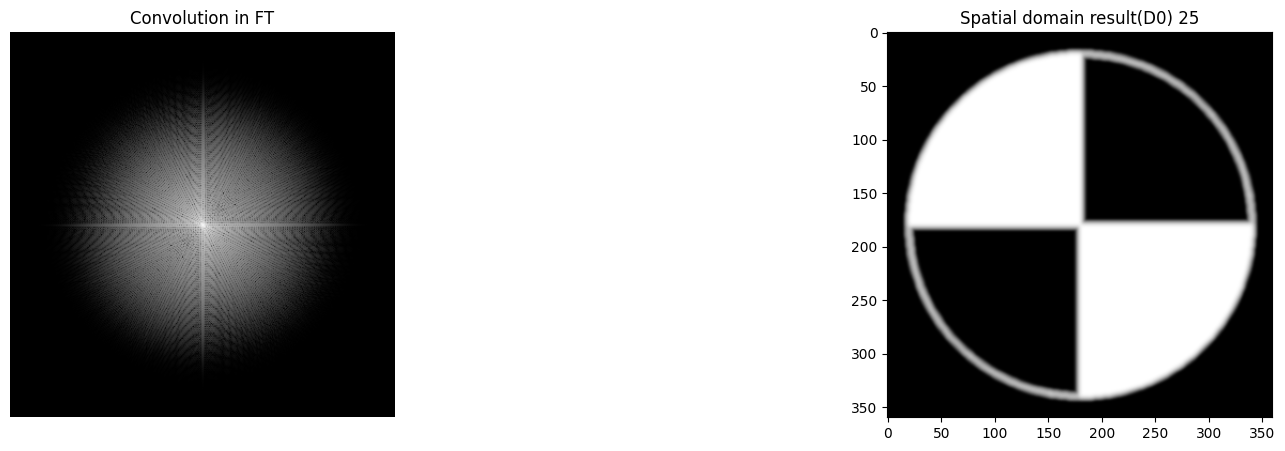

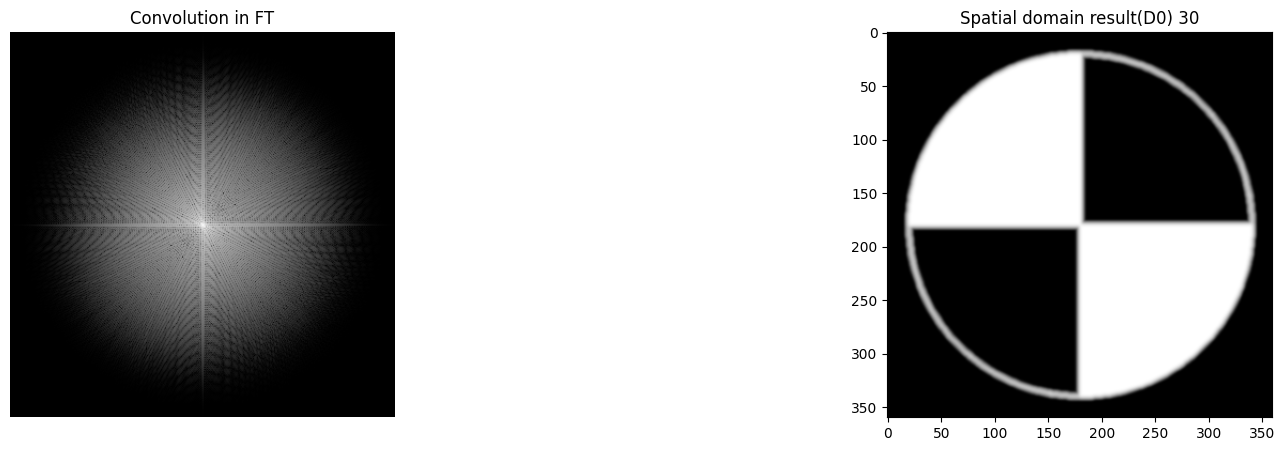

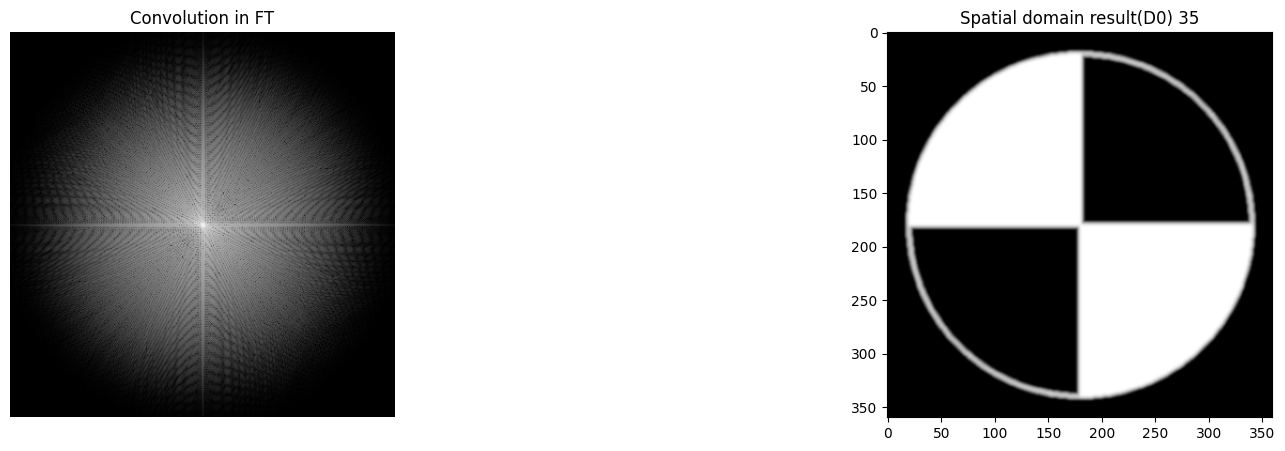

In [27]:
glpf, glp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_freq_filter(gaussian_low_pass_filters[i], image)
  glpf.append(g)
  glp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(glpf[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  plt.imshow(np.log1p(np.abs(glp_applied[i])),cmap='gray')
  plt.title('Spatial domain result' + str('(D0) ') + str(i * 5))
  plt.axis('on')

plt.show()